# Mean Seat Test

* 2016 Presidential 

* 2016 US House 

* 2017 State House G17DHOD 

* 2018 US Senate Race

Use CD12 & CD16 plans and above 4 elections to see how many seats each party would get

In [1]:
import geopandas as gpd
import pandas as pd
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
import random

import numpy as np

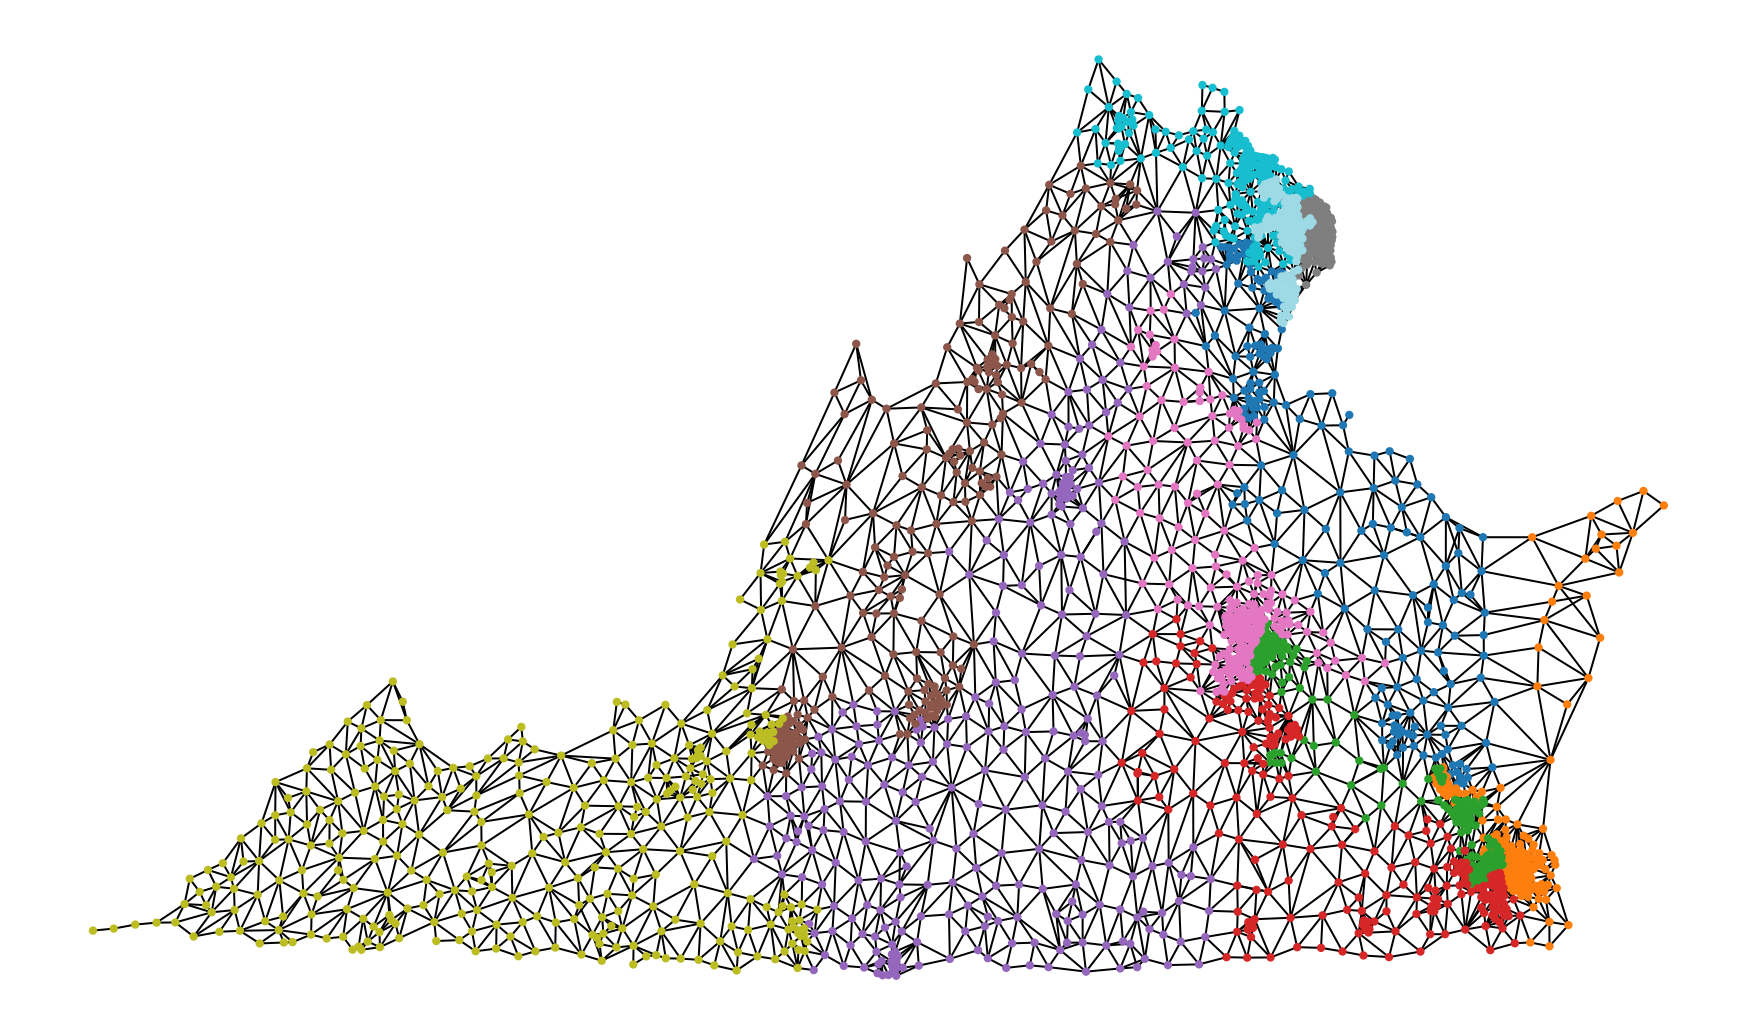

In [2]:
graph = Graph.from_json("./DSSG_Data/VA_Chain.json")
df = gpd.read_file("./DSSG_Data/VA_precincts.shp")
nx.draw(graph,pos = {node:(graph.nodes[node]["C_X"],graph.nodes[node]["C_Y"]) for node in graph.nodes()},node_color=[graph.nodes[node]["CD_12"] for node in graph.nodes()],node_size=10,cmap='tab20')

In [3]:
def convert_attributes_to_float(graph, attribute_list):
    """
     helper function for casting attributes from string to float
     """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = float(graph.nodes[n][attribute])
    return graph


In [6]:
election_names = [
    "BVAP",
    "USHouse16",
    "Pres16",
    "StateHouse17",
    "Sen18",
    ]

election_columns = [
    ["BVAP", "nBVAP"],
    ["G16DHOR","G16RHOR"],
    ["G16DPRS","G16RPRS"],
    ["G17DHOD", "G17RHOD"],
    ["G18DSEN","G18RSEN"]
    ]

party_cols = [ ["G16DHOR","G16RHOR", "G16OHOR"],
               ["G16DPRS","G16RPRS", "G16OPRS"],
               ["G17DHOD", "G17RHOD", "G17OHOD"],
               ["G18DSEN","G18RSEN", "G18OSEN"] ]


graph = convert_attributes_to_float(graph, np.array(party_cols).flatten())

for node in graph.nodes():
    graph.nodes[node]["nBVAP"] = graph.nodes[node]["VAP"] - graph.nodes[node]["BVAP"]
    

# update dataframe to be consistent with graph data
df['nBVAP'] = df['VAP'] - df['BVAP'] # new cols
col_names = np.array(party_cols).flatten()

for col in col_names:
    df[col] = df[col].astype(float)
    
# turnout per election
turnouts = [(df[party_list].sum().sum()/df[['VAP']].sum())[0] for party_list in party_cols]
turnouts

In [0]:
# custom updater functions

# upweight presdiential elections by taking sum across all elections & treating as single election

def calc_seats_single_election(partition):
    total_votes_party1 = [] 
    total_votes_party2 = [] 
           
    for election in election_names[1:]:
        total_votes_party1.append(partition[election].votes('First'))
        total_votes_party2.append(partition[election].votes('Second'))
    
    total_1 = np.array(total_votes_party1).sum(axis=0)
    total_2 = np.array(total_votes_party2).sum(axis=0)
    return sum(total_1 > total_2)


# downweight presidential elections
def calc_seats_equal_weight_election(partition):    
    total_votes_party1 = [] 
    total_votes_party2 = [] 
           
    for election in election_names[1:]:
        total_votes_party1.append(partition[election].votes('First'))
        total_votes_party2.append(partition[election].votes('Second'))
    
    # extrapolate votes to full turnout if same voting patterns observed for each election
    inverse_turnout = 1/np.array(turnouts).reshape(4,1)
    normalized_p1 = np.array(total_votes_party1).T@inverse_turnout
    normalized_p2 = np.array(total_votes_party2).T@inverse_turnout
        
    return sum(normalized_p1 > normalized_p2)[0]

In [0]:
updater = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "single_election": calc_seats_single_election,
    "equal_election": calc_seats_equal_weight_election
}


elections = [
    Election(
        election_names[i],
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
    )
    for i in range(len(election_names))
]

election_updaters = {election.name: election for election in elections}

updater.update(election_updaters)


In [7]:
def calc_seats(party_columns, district_votes):
    return sum(district_votes[party_columns[0]] > district_votes[party_columns[1]])


# 2012 election results
election_results = df.groupby('CD_12').sum()[col_names]
dem_seats_per_election = []

for cols in election_columns[1:]:
    dem_seats_per_election.append(calc_seats(cols, election_results))
    
print(dem_seats_per_election)

# 2016 election results
election_results = df.groupby('CD_16').sum()[col_names]
dem_seats_per_election_rem = []

for cols in election_columns[1:]:
    dem_seats_per_election_rem.append(calc_seats(cols, election_results))
    
print(dem_seats_per_election_rem)


[3, 5, 5, 8]

(-411220.6426873974, 417946.9565434931, 43762.76368719022, 401562.1614498883)

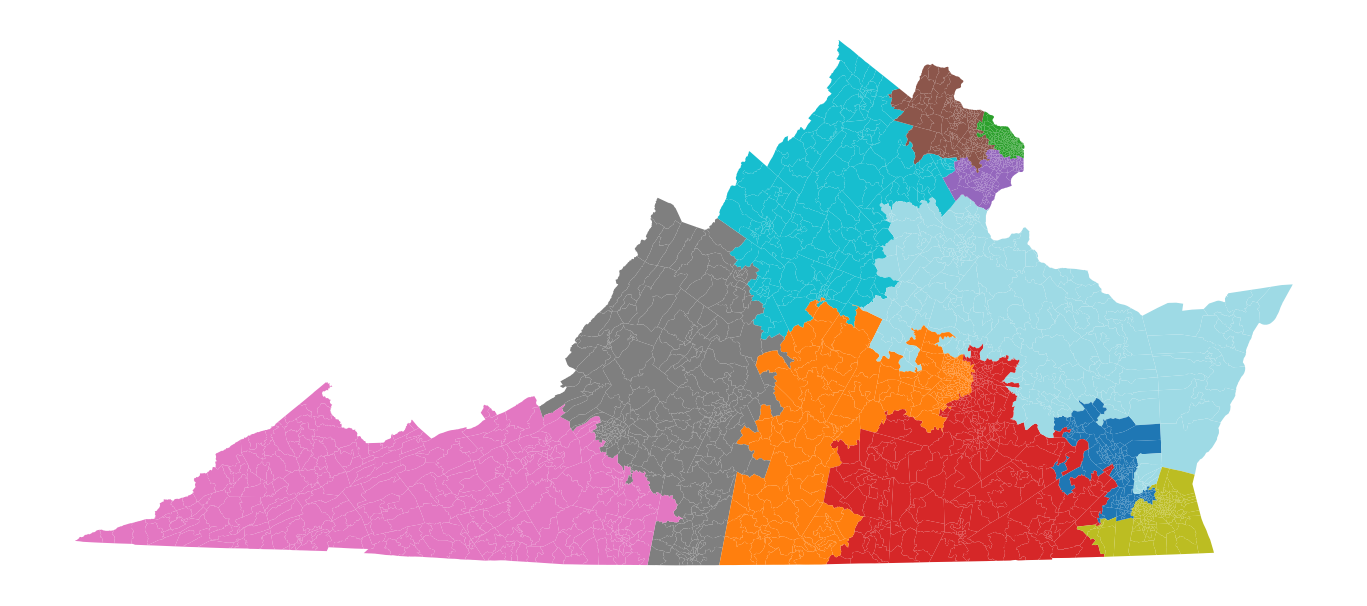

In [10]:
n_districts = 11

cddict =  recursive_tree_part(graph,range(n_districts),df['TOTPOP'].sum()/n_districts,"TOTPOP", .01,1)
df['initial'] = df.index.map(cddict)
df.plot(column='initial',cmap='tab20')
plt.axis('off')

Seed Plans

In [11]:
#Creates initial partition
initial_partition = Partition(graph, cddict, updater)
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition
)

#Creates partition for original enacted 2012 plan
CD_12_assignment = {node: int(graph.nodes()[node]['CD_12']) for node in graph.nodes()}

CD_12_partition = Partition(graph, CD_12_assignment, updater)

#Creates partition for remedial plan
CD_16_assignment = {node: int(graph.nodes()[node]['CD_16']) for node in graph.nodes()}

CD_16_partition = Partition(graph, CD_16_assignment, updater)

In [12]:
tree_proposal = partial(
    recom, pop_col="TOTPOP", pop_target=ideal_population, \
    epsilon=0.01, node_repeats=1, method = bipartition_tree_random
)


In [13]:
#Creates population balance constraint
popbound = constraints.within_percent_of_ideal_population(initial_partition, 0.05)

In [14]:
#Creates an acceptance function that limits the packing of democratic voters into individual districts
def unpack_accept(part): 
    if max(part["PRES16"].percents("D")) < .65:
        return True
    
    elif max(part["PRES16"].percents("D")) < max(part.parent["PRES16"].percents("D")):
        return True
    
    elif random.random() < max(part.parent["PRES16"].percents("D"))/max(part["PRES16"].percents("D")):
        return True
    else:
        return False
    
def pop_accept(partition):
    if partition["popbound"] < partition.parent["popbound"]:
    # max(abs((pd.Series(initial_partition['population']) - ideal_population)/ideal_population))
        return True
    
    else:
        if random.random() < .1:
            return True
        else:
            return False

In [16]:
#Create compactness bound tied to the 2011 plan that was originally impemented
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(CD_12_partition["cut_edges"])
)


~~2 Acceptance Methods:~~
* always accept
* ~~unpack accept~~


3 proposal methods:
* recom
* flip
* mix

3 seed plans:
* enacted
* remedial
* random recursive bipartition tree plan

Possible Analysis:

* Acceptance function based on population balance
* Different compactness constraint 
* mixing times for different proposal/seeds
* different averaging techniques for test

(1) apply voter turnout weights

* option 1 - downweight presidential elections

* option 2 - upweight presidential elections 

*_sum across different elections [treat as single election]_*
    
(2) naive average


 -> consider normalizing @ precinct level?




In [295]:
print(df.groupby('CD_12').TOTPOP.sum().min())
print(df.groupby('CD_12').TOTPOP.sum().max())


print(df.TOTPOP.sum()/11)
(763051.9993695278- 727365.8181426955)/727365.8181426955


699644.0001874466
763051.9993695278
727365.8181426955


0.049062219225472825

In [46]:

# chain = MarkovChain(
#     proposal=tree_proposal,
#     constraints=[popbound,
#                 compactness_bound],
#     accept=unpack_accept,
#     initial_state=initial_partition,
#     total_steps=1000
# )

STEPS = 1000

#1
recom_random_chain = MarkovChain(
    proposal=tree_proposal,
    constraints=[popbound,
                compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps= STEPS
)

#2
recom_enacted_chain = MarkovChain(
    proposal=tree_proposal,
    constraints=[popbound,
                compactness_bound],
    accept=accept.always_accept,
    initial_state=CD_12_partition,
    total_steps= STEPS
)

#3
recom_remedial_chain = MarkovChain(
    proposal=tree_proposal,
    constraints=[popbound,
                compactness_bound],
    accept=accept.always_accept,
    initial_state=CD_16_partition,
    total_steps=STEPS
)

#4
flip_random_chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[popbound,
                compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=STEPS*10
)

#5
flip_enacted_chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[popbound,
                compactness_bound],
    accept=accept.always_accept,
    initial_state=CD_12_partition,
    total_steps=STEPS*10
)

#6
flip_remedial_chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[popbound,
                compactness_bound],
    accept=accept.always_accept,
    initial_state=CD_16_partition,
    total_steps=STEPS*10
)

In [47]:
chain_dict = {
              'flip_random': flip_random_chain,
              'flip_enacted': flip_enacted_chain,
              'flip_remedial': flip_remedial_chain,
              'recom_random': recom_random_chain,
              'recom_enacted': recom_enacted_chain,
              'recom_remedial': recom_remedial_chain,
             }

seats_per_chain = {chain_name: {} for chain_name in chain_dict.keys()}

for name, chain in chain_dict.items():
    print(name)
    seat_counts = []
    seat_counts_single = []
    seat_counts_equal = []
    for part in chain.with_progress_bar():
        seats_per_election = [part[election].wins('First') for election in election_names[1:]]
        
        seat_counts.append(seats_per_election)
        seat_counts_single.append(part["single_election"])
        seat_counts_equal.append(part["equal_election"])
    
    seats_per_chain[name]['standard'] = np.array(seat_counts)
    seats_per_chain[name]['single_sum'] = np.array(seat_counts_single)
    seats_per_chain[name]['equal_weight'] = np.array(seat_counts_equal)


flip_random



flip_enacted



flip_remedial



recom_random



recom_enacted



recom_remedial


In [48]:
import seaborn as sns

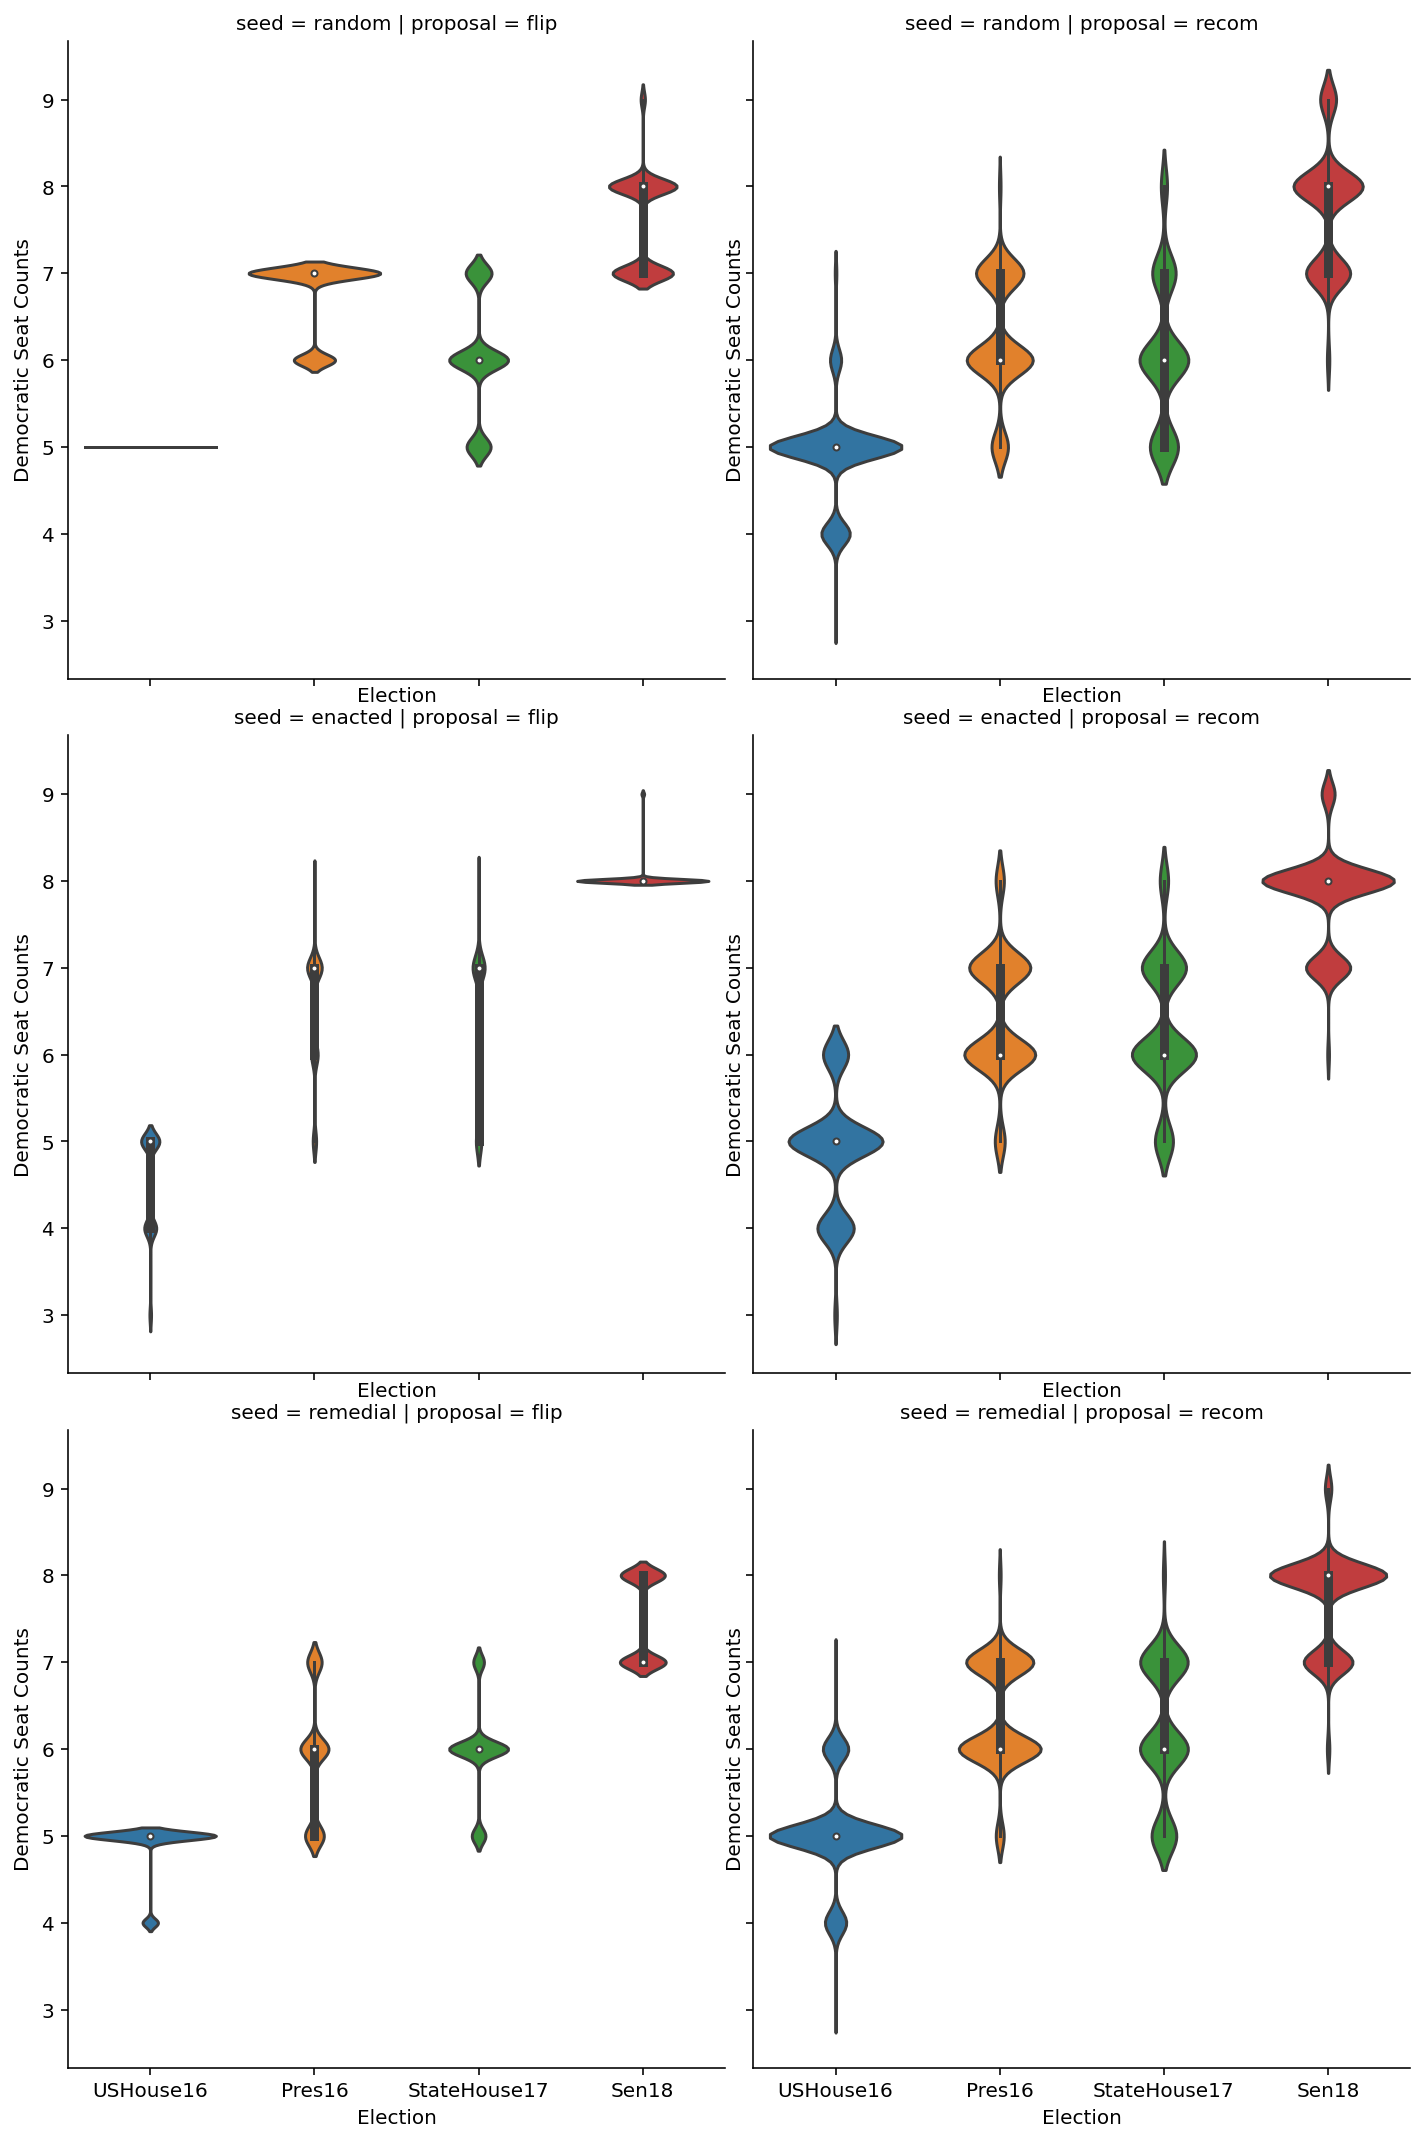

In [139]:
all_counts = []
for chain_name, seat_dict in seats_per_chain.items():
    _df = pd.DataFrame(seat_dict['standard'], columns = election_names[1:])
    _df['chain_type'] = chain_name
    all_counts.append(_df)
    
counts_long = pd.melt(pd.concat(all_counts), 
                  id_vars = ['chain_type'], 
                  value_vars = election_names[1:])

counts_long = pd.concat([counts_long, 
                         counts_long.chain_type.str.split('_').apply(pd.Series)],
                         axis = 1)

counts_long.columns = ['chain_type', 'election', 'seats', 'proposal', 'seed']

ax = sns.catplot(data = counts_long, row = 'seed', col = 'proposal', kind = 'violin',
                 x = 'election', y = 'seats')
ax.set(xlabel = 'Election', ylabel = 'Democratic Seat Counts', )

[Text(0.5, 0, 'Election'),
 Text(0, 0.5, 'Democratic Seat Counts'),
 Text(0.5, 1.0, 'Democrat Performance Across Elections')]

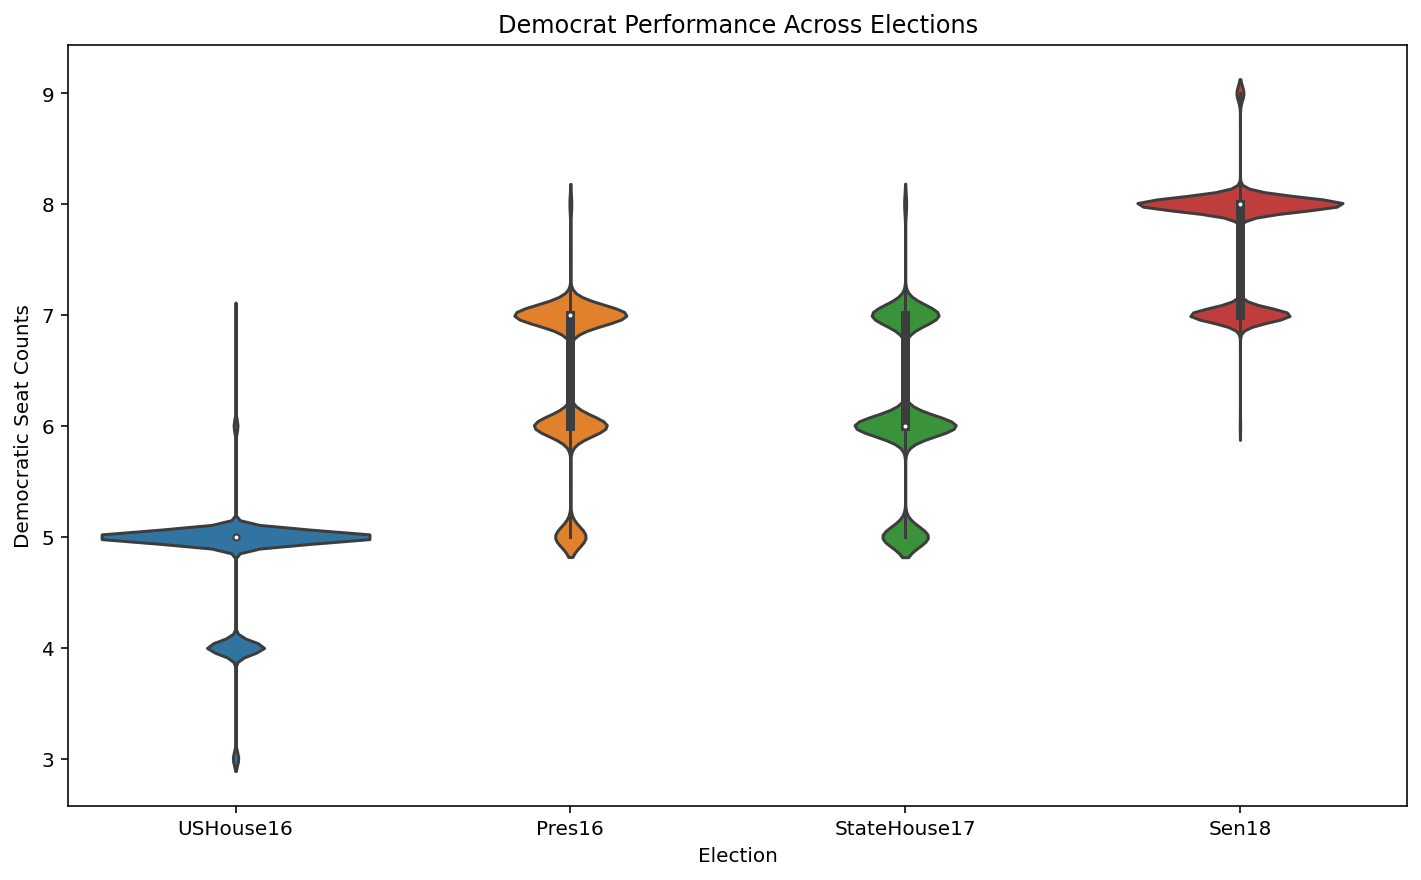

In [58]:
ax = sns.violinplot(data = counts_long, 
                 x = 'election', y = 'seats')

ax.set(xlabel = 'Election', ylabel = 'Democratic Seat Counts', title = 'Democrat Performance Across Elections')

In [149]:
# Option 1 - Average across all chains/elections/steps

avg1 = counts_long.groupby('chain_type').seats.mean()
std1 = counts_long.groupby('chain_type').seats.std()

print('Average:', avg1)
print('Std:', std1)

test_df = pd.DataFrame({'average': avg1, 'standard_dev': std1})
test_df['avg-std'] = test_df.average - test_df.standard_dev
test_df['avg+std'] = test_df.average + test_df.standard_dev

test_df

Average: chain_type
flip_enacted      6.345050
flip_random       6.338725
flip_remedial     6.069525
recom_enacted     6.371000
recom_random      6.249250
recom_remedial    6.341500
Name: seats, dtype: float64
Std: chain_type
flip_enacted      1.399353
flip_random       1.067084
flip_remedial     1.072343
recom_enacted     1.237029
recom_random      1.221883
recom_remedial    1.144205
Name: seats, dtype: float64


,average,standard_dev,avg-std,avg+std
chain_type,,,,
flip_enacted,6.345050,1.399353,4.945697,7.744403
flip_random,6.338725,1.067084,5.271641,7.405809
flip_remedial,6.069525,1.072343,4.997182,7.141868
recom_enacted,6.371000,1.237029,5.133971,7.608029
recom_random,6.249250,1.221883,5.027367,7.471133
recom_remedial,6.341500,1.144205,5.197295,7.485705


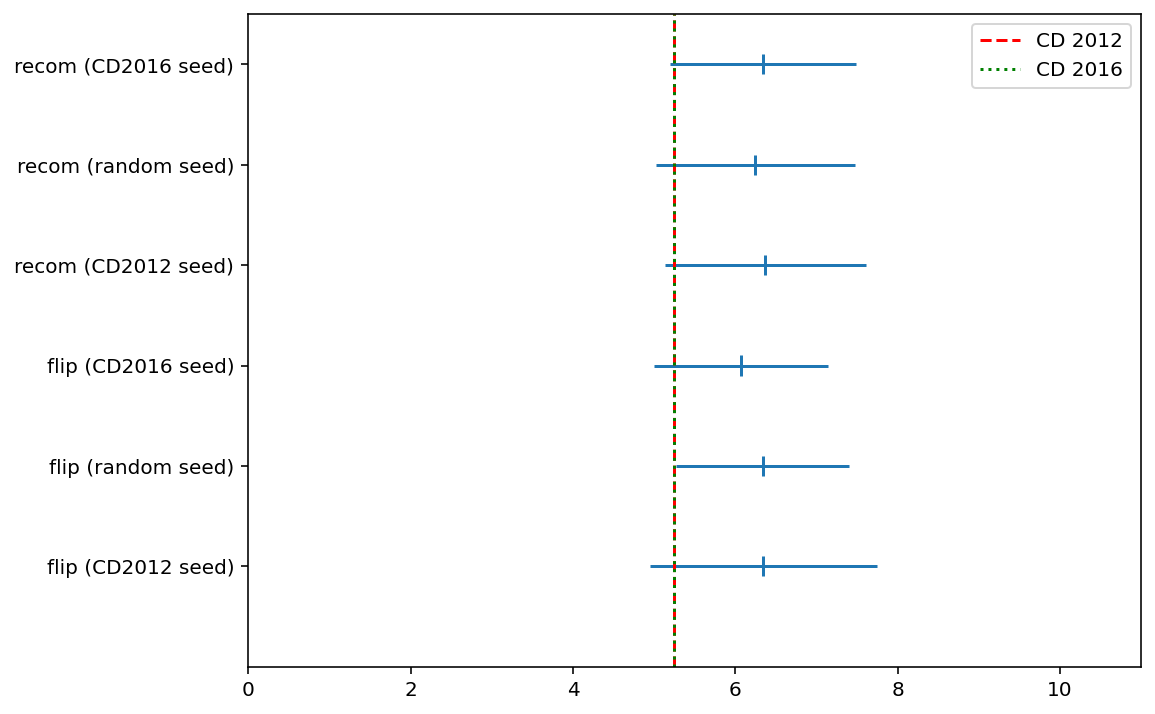

In [150]:
test_df.rename({'recom_remedial': 'recom (CD2016 seed)',
                'recom_random': 'recom (random seed)',
                'recom_enacted': 'recom (CD2012 seed)',
                'flip_remedial': 'flip (CD2016 seed)',
                'flip_random': 'flip (random seed)',
                'flip_enacted': 'flip (CD2012 seed)'
               }, axis = 0, inplace=True)
plt.figure(figsize=(8,6))
y = 0
for i, row in test_df.iterrows():
    ax = plt.hlines(i, row['avg-std'], row['avg+std'])
    plt.vlines(row['average'], y-0.1, y+0.1)
    y+=1

plt.vlines(np.mean(dem_seats_per_election), -1, 5.5, linestyles='dashed', colors ='r', label='CD 2012')    
plt.vlines( np.mean(dem_seats_per_election_rem), -1, 5.5, colors='g', linestyles='dotted', label='CD 2016')    
plt.axis([0, 11, -1, 5.5])
plt.legend()


In [130]:
single_counts = []
for chain_name, seat_dict in seats_per_chain.items():
    _df = pd.DataFrame(seat_dict['single_sum'], columns = ['seats'])
    _df['chain_type'] = chain_name
    single_counts.append(_df)
    
single_counts = pd.concat(single_counts)
single_counts = pd.concat([single_counts, 
                         single_counts.chain_type.str.split('_').apply(pd.Series)],
                         axis = 1)

single_counts.columns = ['seats', 'chain_type', 'proposal', 'seed']



Average: chain_type
flip_enacted      6.5859
flip_random       6.6654
flip_remedial     5.8566
recom_enacted     6.3200
recom_random      6.1240
recom_remedial    6.2940
Name: seats, dtype: float64
Std: chain_type
flip_enacted      0.908022
flip_random       0.471874
flip_remedial     0.793410
recom_enacted     0.732213
recom_random      0.788191
recom_remedial    0.691406
Name: seats, dtype: float64


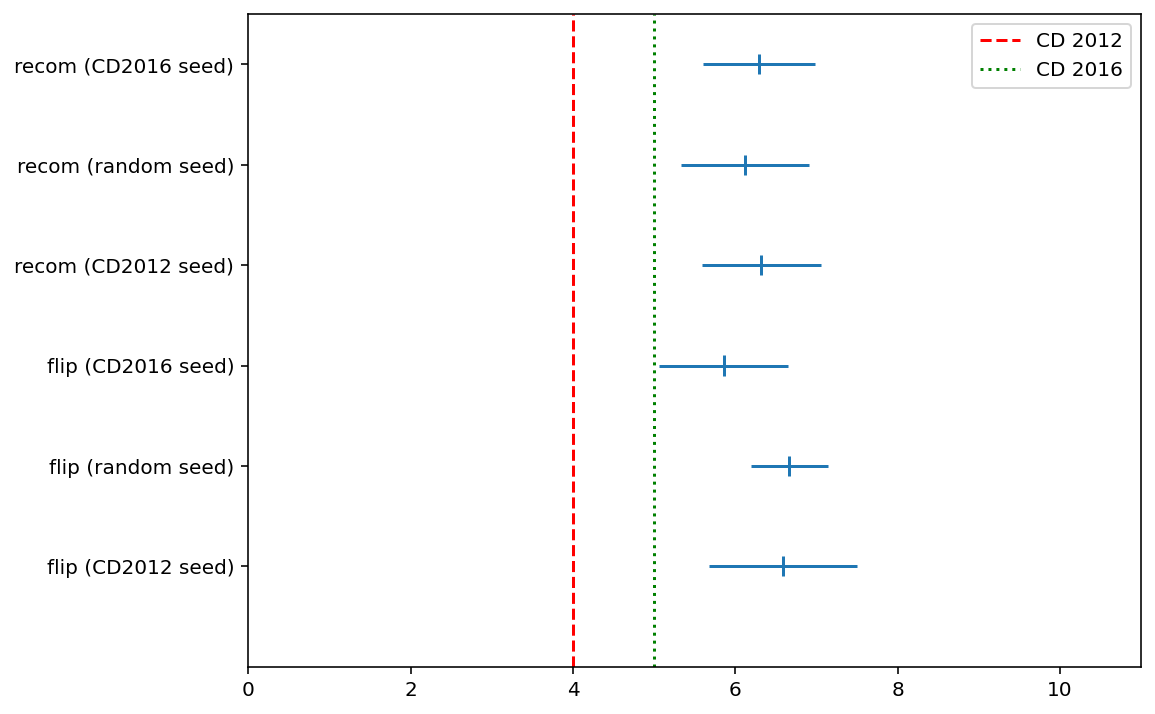

In [152]:
# Option 2 - Sum across elections

avg1 = single_counts.groupby('chain_type').seats.mean()
std1 = single_counts.groupby('chain_type').seats.std()

print('Average:', avg1)
print('Std:', std1)

test_df = pd.DataFrame({'average': avg1, 'standard_dev': std1})
test_df['avg-std'] = test_df.average - test_df.standard_dev
test_df['avg+std'] = test_df.average + test_df.standard_dev

test_df.rename({'recom_remedial': 'recom (CD2016 seed)',
                'recom_random': 'recom (random seed)',
                'recom_enacted': 'recom (CD2012 seed)',
                'flip_remedial': 'flip (CD2016 seed)',
                'flip_random': 'flip (random seed)',
                'flip_enacted': 'flip (CD2012 seed)'
               }, axis = 0, inplace=True)

plt.figure(figsize=(8,6))

y = 0
for i, row in test_df.iterrows():
    ax = plt.hlines(i, row['avg-std'], row['avg+std'])
    plt.vlines(row['average'], y-0.1, y+0.1)
    y+=1

plt.vlines(calc_seats_single_election(CD_12_partition), -1, 5.5, linestyles='dashed', colors ='r', label='CD 2012')    
plt.vlines(calc_seats_single_election(CD_16_partition), -1, 5.5, colors='g', linestyles='dotted', label='CD 2016')    
plt.axis([0, 11, -1, 5.5])
plt.legend()

In [121]:
equal_counts = []
for chain_name, seat_dict in seats_per_chain.items():
    _df = pd.DataFrame(seat_dict['equal_weight'], columns = ['seats'])
    _df['chain_type'] = chain_name
    equal_counts.append(_df)
    
equal_counts = pd.concat(equal_counts)
equal_counts = pd.concat([equal_counts, 
                         equal_counts.chain_type.str.split('_').apply(pd.Series)],
                         axis = 1)

equal_counts.columns = ['seats', 'chain_type', 'proposal', 'seed']

Average: chain_type
flip_enacted      6.6682
flip_random       6.6768
flip_remedial     5.9387
recom_enacted     6.4080
recom_random      6.1350
recom_remedial    6.3090
Name: seats, dtype: float64
Std: chain_type
flip_enacted      0.883282
flip_random       0.467722
flip_remedial     0.792089
recom_enacted     0.745716
recom_random      0.803381
recom_remedial    0.691373
Name: seats, dtype: float64


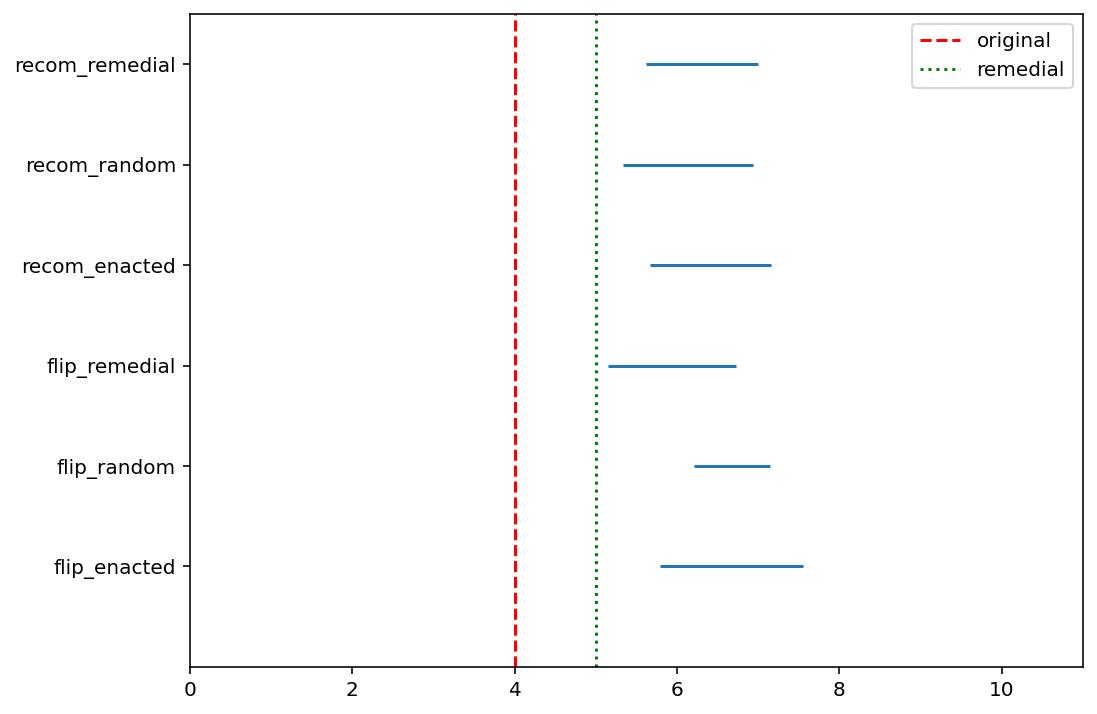

In [128]:
# Option 2 - equal weight elections

avg1 = equal_counts.groupby('chain_type').seats.mean()
std1 = equal_counts.groupby('chain_type').seats.std()

print('Average:', avg1)
print('Std:', std1)

test_df = pd.DataFrame({'average': avg1, 'standard_dev': std1})
test_df['avg-std'] = test_df.average - test_df.standard_dev
test_df['avg+std'] = test_df.average + test_df.standard_dev

plt.figure(figsize=(8,6))
for i, row in test_df.iterrows():
    ax = plt.hlines(i, row['avg-std'], row['avg+std'])

plt.vlines(calc_seats_equal_weight_election(CD_12_partition), -1, 5.5, linestyles='dashed', colors ='r', label='original')    
plt.vlines(calc_seats_equal_weight_election(CD_16_partition), -1, 5.5, colors='g', linestyles='dotted', label='remedial')    
plt.axis([0, 11, -1, 5.5])
plt.legend()


In [137]:

calc_seats_single_election(CD_12_partition)

4